##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 3 - 使用 LangGraph 和 Gemini API 构建代理

欢迎回到 Kaggle 5天生成式 AI 课程！

在本教程中，你将使用 [LangGraph](https://www.langchain.com/langgraph) 来定义一个基于 Gemini API 构建的、具有状态的图形应用程序。

你将构建一个名为 BaristaBot 的模拟咖啡厅点餐系统。它将为顾客提供一个循环的聊天界面，让他们可以使用自然语言订购咖啡饮品，你将构建节点来表示咖啡厅的实时菜单和"后台"订单系统。

BaristaBot 在其他 Gemini API 示例中也有使用，如果你想探索一个更简单的实现，可以查看 [BaristaBot function calling example](https://github.com/google-gemini/cookbook/blob/main/examples/Agents_Function_Calling_Barista_Bot.ipynb)，它仅使用 Gemini API Python SDK 和函数调用来实现类似的系统。

## **重要提示！**

本教程中构建的应用程序使用**文本框**([Python 的 `input`](https://docs.python.org/3/library/functions.html#input))来接收**用户输入**。这些代码被注释掉以确保你可以使用"全部运行"功能而不会中断。注意在需要与应用程序交互的步骤中取消对 `.invoke(...)` 调用的注释。

## 寻求帮助

**常见问题请参考 [FAQ 和故障排除指南](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs)。**

## Get set up

Start by installing and importing the LangGraph SDK and LangChain support for the Gemini API.

In [4]:
%pip install -qU 'langgraph==0.2.45' 'langchain-google-genai==2.0.4'

Note: you may need to restart the kernel to use updated packages.


You may see output containing `ERROR: pip's dependency resolver does not currently take into account all the packages that are installed` - this is OK, the packages are still installed and compatible for this codelab.

You do not neeed to restart the kernel.

### Set up your API key

The `GOOGLE_API_KEY` environment variable can be set to automatically configure the underlying API. This works for both the official Gemini Python SDK and for LangChain/LangGraph. 

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [2]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)

## 关键概念

LangGraph 应用程序是围绕**图**结构构建的。作为开发者，你需要定义一个应用程序图来模拟应用程序的状态转换。你的应用程序将定义一个**状态**模式，这个状态模式的实例会在图中传播。

图中的每个**节点**代表一个可以执行的动作或步骤。节点将通过你定义的代码以某种方式改变状态。这些改变可以是调用 LLM 的结果，也可以是调用 API 的结果，或执行节点定义的任何逻辑。

图中的每条**边**代表状态之间的转换，定义了程序的流程。边的转换可以是固定的，例如，如果你定义了一个纯文本聊天机器人，输出总是显示给用户，那么你可能总是从 `chatbot -> user` 转换。转换也可以是有条件的，允许你添加分支（类似 `if-else` 语句）或循环（类似 `for` 或 `while` 循环）。

LangGraph 具有高度的可扩展性，提供了许多不属于本教程的功能，如内存、持久性和流式处理。要更好地理解 LangGraph 背后的关键概念和理念，请查看他们的 [Conceptual guides](https://langchain-ai.github.io/langgraph/concepts/) 和 [High-level overview](https://langchain-ai.github.io/langgraph/concepts/high_level/)。

## 定义核心指令

状态是 LangGraph 应用程序的一个基本概念。状态对象在应用程序的每个节点和转换之间传递。这里你将定义一个状态对象 `OrderState`，它包含会话历史、结构化订单，以及一个表示客户是否完成下单的标志。为了简单起见，此订单中的"结构"仅是一个字符串列表，但它可以扩展为任何 Python 数据结构。

在 Python 中，LangGraph 状态对象是一个 Python [字典](https://docs.python.org/3/library/stdtypes.html#dict)。你可以通过将其定义为 [`TypedDict`](https://docs.python.org/3/library/typing.html#typing.TypedDict) 来为这个字典提供模式。

这里你还将定义 Gemini 模型将使用的系统指令。你可以在这里设定语气和风格，以及聊天机器人应该遵循的规则。

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# 定义订单状态类，继承自TypedDict
class OrderState(TypedDict):
    """表示客户订单对话的状态"""

    # messages: 聊天对话记录
    # Annotated[list, add_messages] 表示状态更新时是追加消息而不是替换
    messages: Annotated[list, add_messages]

    # order: 客户正在进行中的订单
    # 使用字符串列表存储订单内容
    order: list[str]

    # finished: 表示订单是否已完成的标志
    finished: bool


# 定义系统指令，用于设置聊天机器人的行为规则
# 包括:函数调用规则、对话语气、允许讨论的内容范围等
BARISTABOT_SYSINT = (
    "system",  # 'system' 表示这是一条系统指令
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!",
)

# 定义欢迎消息，这是系统开始对话时显示的第一条消息
# 告知用户可以使用 'q' 退出系统
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

## 定义单轮聊天机器人

为了说明 LangGraph 是如何工作的，下面的程序定义了一个聊天机器人节点，它将使用提供的指令执行一轮对话。

图中的每个节点都对状态对象进行操作。状态（一个 Python 字典）作为参数传入节点（一个函数），并返回新的状态。这可以用伪代码表示为：`state = node(state)`。

注意：对于 `chatbot` 节点，状态是通过*添加*新的对话消息来更新的。`OrderState.messages` 上的 `add_messages` 注解表示从节点返回时消息是被*追加*的。通常状态是通过替换来更新的，但这个注解使得 `messages` 的行为有所不同。

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# 初始化 Gemini 模型
# 可以尝试使用不同的模型:
# - pro 模型在工具调用方面表现最好
# - flash 模型速度快,适合需要使用更高免费配额的场景
# 查看功能和配额差异: https://ai.google.dev/pricing
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")


def chatbot(state: OrderState) -> OrderState:
    """聊天机器人核心功能。简单封装模型的聊天接口"""
    # 构建消息历史:系统指令 + 已有对话记录
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    # 调用模型进行对话,返回新的消息
    return {"messages": [llm.invoke(message_history)]}


# 基于状态定义创建初始图
graph_builder = StateGraph(OrderState)

# 将chatbot函数作为名为"chatbot"的节点添加到应用程序图中
graph_builder.add_node("chatbot", chatbot)

# 将chatbot节点定义为应用程序的入口点
# START 是一个特殊标记,表示图的起始点
graph_builder.add_edge(START, "chatbot")

# 编译图,使其可执行
chat_graph = graph_builder.compile()

It can be helpful to visualise the graph you just defined. The following code renders the graph.

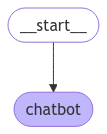

In [9]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

现在图已经定义好了,你可以运行它。它只有一个节点,并且只有一个转换到该节点,所以它会从`__start__`转换到`chatbot`,执行`chatbot`节点,然后终止。

要运行图,你需要调用`invoke`并传递一个初始状态对象。在这个例子中,它从用户的初始消息开始。

In [10]:
from pprint import pprint

# 用户的初始消息
user_msg = "Hello, what can you do?"
# 调用图的invoke方法，传递初始状态对象，获取新的状态
state = chat_graph.invoke({"messages": [user_msg]})

# state对象包含很多信息。取消注释pprint行可以查看所有信息。
# pprint(state)

# 注意最终的state现在有2条消息。一个是HumanMessage，另一个是AIMessage。
for msg in state["messages"]:
    # 打印消息的类型和内容
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Welcome to BaristaBot! I can help you order delicious coffee, tea, pastries, and other treats. What would you like to order today? 

**MENU**

**Coffee:**
* Americano
* Cappuccino
* Latte
* Espresso
* Mocha
* Cold Brew
* Iced Coffee

**Tea:**
* Black Tea
* Green Tea
* Earl Grey
* Chai Tea Latte

**Pastries:**
* Croissant
* Muffin
* Scone
* Cookie

**Modifiers:**
* Sugar
* Milk
* Cream
* Almond Milk
* Soy Milk
* Oat Milk
* Whipped Cream
* Caramel Syrup
* Vanilla Syrup
* Hazelnut Syrup
* Cinnamon
* Chocolate Drizzle 



你可以在Python循环中执行此操作，但为了简单起见，手动调用一次对话轮次。第二次调用将从第一次调用的状态开始，并附加另一条用户消息，以引出chatbot的另一个响应。

In [11]:
# 定义用户的新消息
user_msg = "Oh great, what kinds of latte can you make?"

# 将用户消息添加到当前状态的消息列表中
state["messages"].append(user_msg)

# 使用图重新处理更新后的状态
state = chat_graph.invoke(state)

# 可以取消注释下面这行来查看完整的状态信息
# pprint(state)

# 遍历状态中的所有消息并打印
for msg in state["messages"]:
    # 打印每条消息的类型(HumanMessage/AIMessage)和内容
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Welcome to BaristaBot! I can help you order delicious coffee, tea, pastries, and other treats. What would you like to order today? 

**MENU**

**Coffee:**
* Americano
* Cappuccino
* Latte
* Espresso
* Mocha
* Cold Brew
* Iced Coffee

**Tea:**
* Black Tea
* Green Tea
* Earl Grey
* Chai Tea Latte

**Pastries:**
* Croissant
* Muffin
* Scone
* Cookie

**Modifiers:**
* Sugar
* Milk
* Cream
* Almond Milk
* Soy Milk
* Oat Milk
* Whipped Cream
* Caramel Syrup
* Vanilla Syrup
* Hazelnut Syrup
* Cinnamon
* Chocolate Drizzle 

HumanMessage: Oh great, what kinds of latte can you make?
AIMessage: We have regular Latte, and you can customize it with any of our milk options: Almond Milk, Soy Milk, Oat Milk, or regular Milk. We also have a delicious Chai Tea Latte! 



## 添加 human 节点

不需要在 Python 循环中重复运行 "graph"，你可以使用 LangGraph 在节点之间循环。

`human` 节点会向用户显示来自 LLM 的最后一条消息，然后提示用户输入下一条内容。这里使用标准的 Python `print` 和 `input` 函数来实现，但在真实的咖啡厅场景中，你可以将聊天内容渲染到显示器或音频上，并通过麦克风或屏幕键盘接收输入。

`chatbot` 节点函数也已更新，包含了开始对话的欢迎消息。

In [12]:
# 导入AIMessage类用于生成AI消息
from langchain_core.messages.ai import AIMessage


def human_node(state: OrderState) -> OrderState:
    """显示最后一条模型消息给用户，并接收用户的输入。
    
    Args:
        state: 当前的对话状态对象
        
    Returns:
        更新后的状态对象
    """
    # 获取最后一条消息
    last_msg = state["messages"][-1]
    # 打印模型的消息内容
    print("Model:", last_msg.content)

    # 获取用户输入
    user_input = input("User: ")

    # 检查用户是否想要退出对话
    # 如果输入是q、quit、exit或goodbye中的任何一个,则标记对话结束
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    # 返回更新后的状态,添加用户消息
    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """聊天机器人的主要功能。包装了模型的聊天接口。
    
    Args:
        state: 当前的对话状态对象
        
    Returns:
        更新后的状态对象,包含新的AI回复
    """

    if state["messages"]:
        # 如果已有消息记录,则继续与Gemini模型的对话
        new_output = llm.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        # 如果没有消息记录,则发送欢迎消息
        new_output = AIMessage(content=WELCOME_MSG)

    # 返回更新后的状态,添加AI回复
    return state | {"messages": [new_output]}


# 创建一个新的状态图构建器
graph_builder = StateGraph(OrderState)

# 向应用图中添加chatbot和human节点
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# 设置图的起始节点为chatbot
graph_builder.add_edge(START, "chatbot")

# 添加从chatbot到human的边,表示chatbot回复后总是转到human节点获取用户输入
graph_builder.add_edge("chatbot", "human")

在运行之前请注意,如果你添加了一个从 `human` 返回到 `chatbot` 的边,由于没有退出条件,图会无限循环。一种打破循环的方法是添加对用户输入像 `q` 或 `quit` 这样的检查来中断循环。

在 LangGraph 中,这是通过条件边(conditional edge)来实现的。这类似于常规的图转换,但会调用自定义函数来确定遍历哪条边。

条件边函数接收 state 作为输入,并返回一个字符串,表示它将转换到的节点名称。

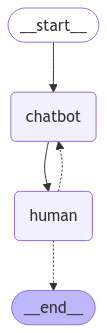

In [13]:
# 导入Literal类型用于类型注解
from typing import Literal


def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """根据用户状态决定是否退出对话。
    
    Args:
        state: 当前的对话状态对象
        
    Returns:
        "chatbot": 继续对话,转到chatbot节点
        "__end__": 结束对话
    """
    # 检查状态中的finished标志
    if state.get("finished", False):
        # 如果finished为True,返回END表示结束对话
        return END
    else:
        # 否则返回"chatbot"继续对话
        return "chatbot"


# 为human节点添加条件边,使用maybe_exit_human_node函数判断转换方向
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# 编译状态图,生成可执行的图对象
chat_with_human_graph = graph_builder.compile()

# 绘制图的可视化表示并显示
Image(chat_with_human_graph.get_graph().draw_mermaid_png())

运行这个新的 graph 来查看交互循环是如何被捕获在图中的。输入 `quit` 退出程序。

**你必须取消注释 `.invoke(...)` 这一行来运行这个步骤。**

In [ ]:
# 请记住,除非你输入 `q`、`quit` 或在 `human_node` 中定义的其他退出词,否则这将无限循环。
# 取消注释下面这行来执行图:
# state = chat_with_human_graph.invoke({"messages": []})

# 可以尝试:
#  - 直接聊天! 目前还没有点单或菜单功能。
#  - 输入 'q' 退出。

# pprint(state)

## 添加"实时"菜单

BaristaBot 目前还不知道咖啡店有哪些可用的商品,所以它会产生一个虚构的菜单。一种选择是将菜单硬编码到系统提示中。这种方法可行,但为了模拟一个菜单更加动态并能响应库存水平变化的系统,你将把菜单放入一个自定义工具中。

这个系统将使用两种类型的工具。可以自动运行的无状态工具,以及修改订单的有状态工具。"获取当前菜单"工具是无状态的,因为它不会对实时订单做任何更改,所以可以自动调用。

在 LangGraph 应用中,你可以通过应用 `@tools` 注解将 Python 函数标注为工具。


In [14]:
# 导入工具装饰器
from langchain_core.tools import tool


# 使用@tool装饰器将函数标记为工具
@tool
def get_menu() -> str:
    """提供最新的菜单信息"""
    # 注意:这里只是硬编码的文本,但你可以:
    # 1. 连接到实时的库存数据库
    # 2. 使用 Gemini 的多模态能力拍摄咖啡店黑板菜单的实时照片
    # 3. 或者拍摄柜台上产品的照片并将它们组合成输入

    return """
    MENU:
    Coffee Drinks:
    Espresso
    Americano
    Cold Brew

    Coffee Drinks with Milk:
    Latte
    Cappuccino
    Cortado
    Macchiato
    Mocha
    Flat White

    Tea Drinks:
    English Breakfast Tea
    Green Tea
    Earl Grey

    Tea Drinks with Milk:
    Chai Latte
    Matcha Latte
    London Fog

    Other Drinks:
    Steamer
    Hot Chocolate

    Modifiers:
    Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
    Espresso shots: Single, Double, Triple, Quadruple; default: Double
    Caffeine: Decaf, Regular; default: Regular
    Hot-Iced: Hot, Iced; Default: Hot
    Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
    Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

    "dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
    "Regular milk" is the same as 'whole milk'.
    "Sweetened" means add some regular sugar, not a sweetener.

    Soy milk has run out of stock today, so soy is not available.
  """

现在将新工具添加到图中. `get_menu` 工具被封装在 [`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) 中, 它负责调用工具并将响应作为消息传递给图. 这些工具也会绑定到 `llm` 对象上, 以便底层模型知道它们的存在. 由于现在有了一个不同的 `llm` 对象来调用, 你需要更新 `chatbot` 节点以使其知道这些工具.


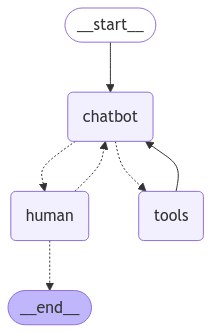

In [15]:
from langgraph.prebuilt import ToolNode


# 定义工具并创建工具节点
tools = [get_menu]
tool_node = ToolNode(tools)

# 将工具绑定到模型上,让模型知道它可以调用哪些工具
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: OrderState) -> Literal["tools", "human"]:
    """在工具节点和人类节点之间路由,取决于是否有工具调用"""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # 只根据最后一条消息进行路由
    msg = msgs[-1]

    # 当聊天机器人返回tool_calls时,路由到"tools"节点
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


def chatbot_with_tools(state: OrderState) -> OrderState:
    """带工具的聊天机器人。是模型自身聊天接口的简单包装器"""
    # 设置默认值
    defaults = {"order": [], "finished": False}

    # 如果有消息历史,则调用模型生成回复
    if state["messages"]:
        new_output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # 如果未设置则使用默认值,然后传递提供的状态,
    # 只覆盖"messages"字段
    return defaults | state | {"messages": [new_output]}


# 创建状态图构建器
graph_builder = StateGraph(OrderState)

# 添加节点,包括新的工具节点
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# 聊天机器人可以转到工具或人类节点
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# 人类节点可以返回聊天机器人或退出
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# 工具节点总是路由回聊天机器人
graph_builder.add_edge("tools", "chatbot")

# 添加起始节点到聊天机器人的边
graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

# 绘制图形
Image(graph_with_menu.get_graph().draw_mermaid_png())

Now run the new graph to see how the model uses the menu.

**You must uncomment the `.invoke(...)` line to run this step.**

In [ ]:
# 请记住,你还没有实现点单功能,所以这会无限循环,
# 除非你输入 `q`、`quit` 或在 `human_node` 中定义的其他退出词。
# 取消下面这行的注释来执行图:
# state = graph_with_menu.invoke({"messages": []})

# 可以尝试:
# - 我想要一杯浓缩咖啡,你们有什么?
# - 你们有什么茶?
# - 你们能做长黑咖啡吗?(菜单上显示为 "Americano" - 看看它能否理解)
# - 输入 'q' 退出

# pprint(state)

## 处理订单

在聊天对话过程中构建订单时,你需要更新状态来跟踪订单,并提供简单的工具来更新这个状态。这些需要明确定义,因为模型不应该直接访问应用程序的内部状态,否则可能会被任意操纵。

订单工具将作为存根添加到单独的节点中,这样你就可以直接编辑状态。使用 `@tool` 注解仍然是定义它们的 schema 的便捷方式,所以下面的订单工具被实现为空的 Python 函数。

In [16]:
from collections.abc import Iterable
from random import randint

from langgraph.prebuilt import InjectedState
from langchain_core.messages.tool import ToolMessage

# 这些函数没有具体实现;因为 LangGraph 不允许 @tools 直接更新对话状态
# 所以我们将在单独的 order_node 中实现状态更新
# 使用 @tools 仍然方便定义工具的 schema,所以这里定义空函数
# 这些函数会绑定到 LLM 上,但具体实现在 order_node 中


@tool
def add_to_order(drink: str, modifiers: Iterable[str]) -> str:
    """添加指定的饮品到客户订单中,包括任何修饰词
    
    Returns:
      更新后的进行中订单
    """


@tool
def confirm_order() -> str:
    """询问客户订单是否正确
    
    Returns:
      用户的自由文本响应
    """


@tool
def get_order() -> str:
    """返回用户当前的订单,每行一个商品"""


@tool
def clear_order():
    """清空用户的订单"""


@tool
def place_order() -> int:
    """将订单发送给咖啡师执行
    
    Returns:
      预计等待分钟数
    """


def order_node(state: OrderState) -> OrderState:
    """订单处理节点,在这里操作订单状态"""
    # 获取最后一条消息
    tool_msg = state.get("messages", [])[-1]
    # 获取当前订单
    order = state.get("order", [])
    # 存储要发送的消息
    outbound_msgs = []
    # 订单是否已下单标志
    order_placed = False

    # 处理每个工具调用
    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_to_order":
            # 每个订单项就是一个字符串,格式为 "drink (modifiers, ...)"
            modifiers = tool_call["args"]["modifiers"]
            modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"

            order.append(f'{tool_call["args"]["drink"]} ({modifier_str})')
            response = "\n".join(order)

        elif tool_call["name"] == "confirm_order":
            # 我们可以让 LLM 来确认订单,但最好向用户展示准确的订单数据
            # 这样可以避免 LLM 产生幻觉或与实际不符
            
            # 在真实场景中,这里会连接到 POS 屏幕来显示订单

            print("Your order:")
            if not order:
                print("  (no items)")

            for drink in order:
                print(f"  {drink}")

            response = input("Is this correct? ")

        elif tool_call["name"] == "get_order":
            # 返回当前订单,如果为空则返回"(no order)"
            response = "\n".join(order) if order else "(no order)"

        elif tool_call["name"] == "clear_order":
            # 清空订单
            order.clear()
            response = None

        elif tool_call["name"] == "place_order":
            # 下单处理
            order_text = "\n".join(order)
            print("Sending order to kitchen!")
            print(order_text)

            # TODO: 实现咖啡厅后端
            order_placed = True
            response = randint(1, 5)  # 随机生成等待时间(分钟)

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # 记录工具调用结果为工具消息
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "order": order, "finished": order_placed}


def maybe_route_to_tools(state: OrderState) -> str:
    """在聊天和工具节点之间路由(如果有工具调用)"""
    # 检查消息是否存在
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # 当订单已下单时,退出应用
        # 系统指令会让聊天机器人说谢谢和再见,然后干净地退出
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # 如果有自动工具调用,优先路由到 tools 节点
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "ordering"

    else:
        return "human"

现在定义这个图。大语言模型(LLM)也需要了解这些工具,以便调用它们。在这里你设置了2组工具,它们对应于它们所操作的节点:自动化(automated)和排序(ordering)。

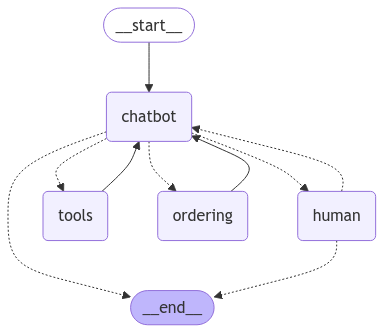

In [17]:
# 定义自动工具列表 - 这些工具会被 ToolNode 自动调用
# 目前只包含获取菜单功能
auto_tools = [get_menu]
tool_node = ToolNode(auto_tools)

# 定义订单相关工具列表 - 这些工具由 order_node 处理
# 包含:添加订单、确认订单、获取订单、清空订单、下单等功能
order_tools = [add_to_order, confirm_order, get_order, clear_order, place_order]

# LLM 需要知道所有可用的工具,所以这里将所有工具都绑定到 LLM
llm_with_tools = llm.bind_tools(auto_tools + order_tools)


# 创建状态图构建器,使用 OrderState 作为状态类型
graph_builder = StateGraph(OrderState)

# 添加节点
# - chatbot: 处理对话的节点
# - human: 处理用户输入的节点  
# - tools: 处理自动工具调用的节点
# - ordering: 处理订单相关操作的节点
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", order_node)

# 添加条件边:从 chatbot 节点出发
# 可以转向: ordering(订单处理)、tools(自动工具)、human(用户交互)或 END(结束)
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)

# 添加条件边:从 human 节点出发
# 可以转向: chatbot(继续对话)或 END(结束)
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# 工具节点(自动工具和订单工具)处理完后都返回到 chatbot 继续对话
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")

# 设置图的起始节点为 chatbot
graph_builder.add_edge(START, "chatbot")

# 编译图,生成可执行的图对象
graph_with_order_tools = graph_builder.compile()

# 生成并显示图的可视化表示
Image(graph_with_order_tools.get_graph().draw_mermaid_png())

Now run the complete ordering system graph.

**You must uncomment the `.invoke(...)` line to run this step.**

In [19]:
# 设置节点遍历的递归限制
# 默认限制是25次,这里增加到100次以支持更复杂的订单流程
# 因为订单可能涉及多次修改和确认等往返操作
config = {"recursion_limit": 100}

# 执行对话图
# 初始状态为空消息列表 {"messages": []}
# config 参数传入上面定义的配置
state = graph_with_order_tools.invoke({"messages": []}, config)

# 测试建议:
# - 点一杯饮品!
# - 修改你的订单
# - 询问"哪些茶来自英国?"
# - 注意:下单完成后图会自动结束执行

# 打印最终的状态信息
pprint(state)

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?


User:  q


{'finished': True,
 'messages': [AIMessage(content='Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?', additional_kwargs={}, response_metadata={}, id='8fdac310-2b47-4192-acc9-82e0f6da0864'),
              HumanMessage(content='q', additional_kwargs={}, response_metadata={}, id='0fd60191-969c-46d7-a2ea-776daa70183c')],
 'order': []}


订单状态已经同时被捕获在 `place_order` 函数中和执行图后返回的最终对话状态中。这说明了如何将你自己的系统集成到图应用中，以及如何收集此类应用执行的最终结果。

In [20]:
pprint(state["order"])

[]


If you see an error 

## 进阶练习

恭喜你使用 LangGraph 和 Gemini API 构建了一个具有代理功能、人机交互、自然语言驱动的咖啡厅点单系统！

这个示例应用可以向多个方向扩展。你应该尝试实现自己的想法，以下是一些启发性建议：

* 为订单添加更多结构化内容(OrderState.order) - 例如为商品、修饰符甚至数量设置独立字段。
* 目前模型只能清除并重新添加商品，所以可以添加一个从订单中remove_item的功能。
* 尝试构建一个显示进行中订单并托管聊天的用户界面。像 Gradio 或 Mesop 这样的框架非常适合实现这个功能。

这个系统对单人点单效果很好，但代理系统可以与多个来源交互。作为一个具有挑战性的扩展练习，试着让这个应用按特定时间表运行，并通过 Chat 联系你的朋友或同事收集他们的日常咖啡订单。